# Fitting resonators

## General usecase
- Import your data as a complex number, make sure your magnitude is **linear**
- Select the correct `measurement` type between `'reflection'`, `'hanger'` and `'transmission'`

Read the SQIL-core documentation to learn about all the options.

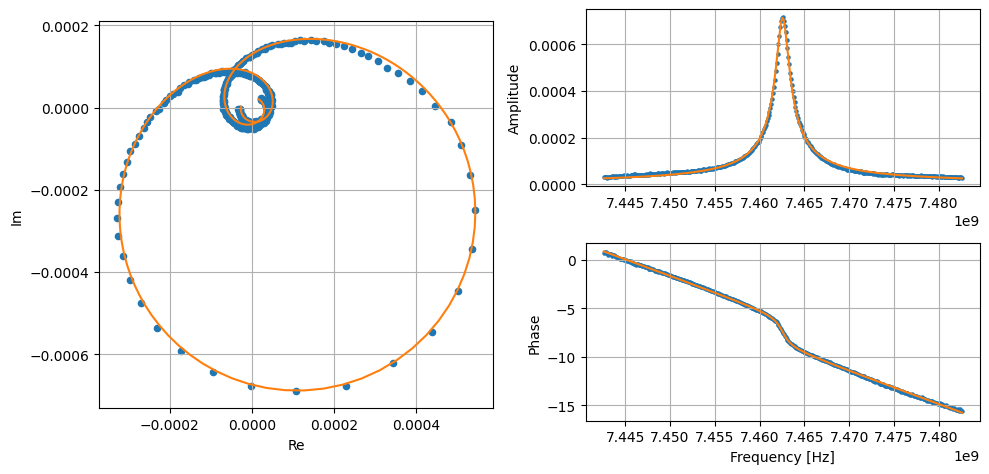

| Param     | Value       |
|-----------|-------------|
| fr        | 7.46257 GHz |
| Q_tot     | 5074        |
| kappa_tot | 1.471 MHz   |


In [7]:
import numpy as np

import sqil_core as sqil

path = r"Z:\Projects\BottomLoader\data\20250612_AQUA_skinny\2025-06-12\00000-pulsed_onetone_2025-06-12T205752"
measurement = "transmission"

freq, data = sqil.extract_h5_data(path, ["ro_freq", "data"])

# Quick fit to estimate parameters
params = sqil.resonator.quick_fit(freq, data, measurement)
# Full fit
fit_res = sqil.resonator.full_fit(freq, data, measurement, *params)

# Plot
x_fit = np.linspace(freq[0], freq[-1], np.max([len(freq), 1000]))
sqil.resonator.plot_resonator(freq, data, x_fit, fit_res.predict(x_fit))

# Print results
sqil.resonator.print_resonator_params(fit_res.params, measurement)

For extra information on your fit run

In [8]:
fit_res.summary();

reduced χ²  2.720e-11             GREAT (or overfitting)
nrmse       5.960e-03-1.300e-04j  GREAT
| Param   |   Fitted value |    STD error |   % Error |
|---------|----------------|--------------|-----------|
| a       |    0.000711667 |    1.566e-06 |      0.22 |
| alpha   |   -0.666959    |    0.01078   |     -1.62 |
| tau     |   -5.40365e-08 |    8.397e-11 |     -0.16 |
| Q_tot   | 5074.46        |   16.21      |      0.32 |
| fr      |    7.46257e+09 | 2285         |      0    |



## Fitting with a background

The magnitude background can create problems for the fit, so we need a way to account for it.

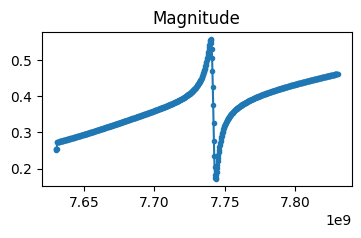

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import sqil_core as sqil

path = r"Z:\Projects\BottomLoader\RT_measurement\20241212_cavities\2024-12-12\00082-cavity_check_2024-12-12T174140"
measurement = "hanger"

[freq], [mag_db], [phase] = sqil.extract_h5_data(path, ["frequency", "mag", "phase"])
linmag = 10 ** (mag_db / 20)
data = linmag * np.exp(1j * phase)
freq = freq


plt.figure(figsize=(4, 2))
plt.title("Magnitude")
plt.plot(freq, linmag, ".-")
plt.show()

Find a way to estimate your background. It's recommended to use a simple fit, linear or at most polynomial.<br>
It could be helpful to take a wider shot of your data.

**IMPORTANT**: The background can be ANY array of the same size as the frequency, so it can be completely arbitrary.

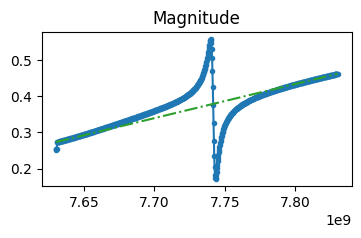

In [10]:
# Estimate the linear background from the last few points
[y0, m] = sqil.estimate_linear_background(freq, linmag, cut_from_back=True)

plt.figure(figsize=(4, 2))
plt.title("Magnitude")
plt.plot(freq, linmag, ".-")
plt.plot(freq, m * freq + y0, "-.", color="tab:green")
plt.show()

Then cut the data closer to the resonance. Don't be afraid to get quite close.<br>
Remmeber to also cut the background!

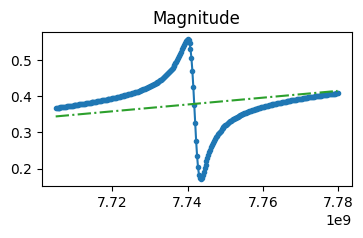

In [11]:
cut = slice(300, 600)
freq, data = freq[cut], data[cut]

# After cutting the data don't forget to define
# the background on the newly cut frequency
mag_bg = m * freq + y0

plt.figure(figsize=(4, 2))
plt.title("Magnitude")
plt.plot(freq, np.abs(data), ".-")
plt.plot(freq, mag_bg, "-.", color="tab:green")
plt.show()

| Param     | Value       |
|-----------|-------------|
| fr        | 7.74145 GHz |
| Re[Q_ext] | 824         |
| Q_int     | 3564        |
| Q_tot     | 2237        |
| kappa_ext | 9.39 MHz    |
| kappa_int | 2.172 MHz   |
| kappa_tot | 3.461 MHz   |


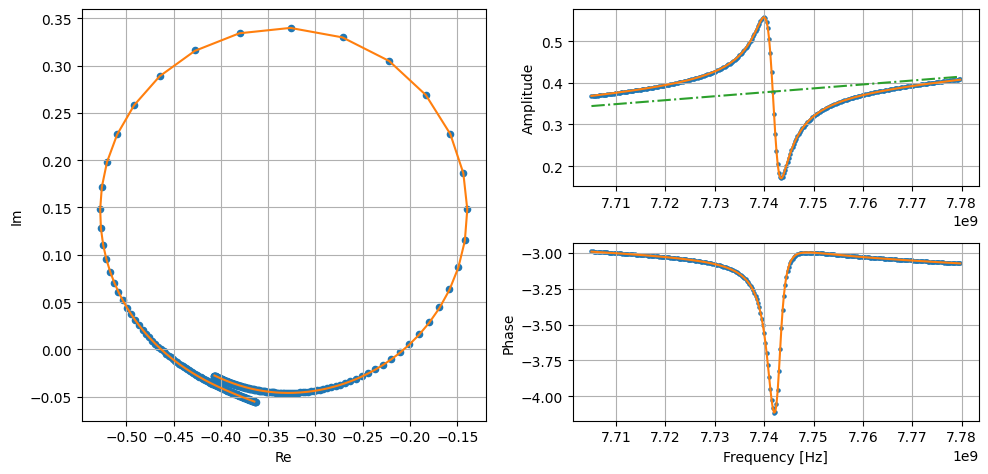

In [12]:
# Quick fit to estimate parameters
params = sqil.resonator.quick_fit(freq, data, measurement, mag_bg=mag_bg)
# Full fit
fit_res = sqil.resonator.full_fit(freq, data, measurement, *params, mag_bg=mag_bg)

# Print results
sqil.resonator.print_resonator_params(fit_res.params, measurement)

# Plot
sqil.resonator.plot_resonator(freq, data, freq, fit_res.predict(freq), mag_bg=mag_bg)